# Estatística no futebol

### A duração de um técnico, no futebol, influencia na posição final do campeonato?



#### Descrição do problema

Uma posição _volátil_, no futebol (tanto no Brasil quanto fora), é a posição de técnico. Uma prática comum é substituir o treinador após alguns resultados negativos. Naturalmente, um time que não troca o técnico não é garantia de sucesso no campeonato. Assim, surge a dúvida: será que, **em geral**, times com técnicos mais longevos ficam em uma posição melhor na tabela, no fim do campeonato?

#### Dados

Para _atacar_ esse problema, será disponibilizado um arquivo json com todos os dados do Campeonato Brasileiro de 2019. Para ler um arquivo json, basta importar o módulo 'pandas' com o comando:  ```import pandas as pd```. Para ler um arquivo json, utilize o método:  
```dados = pd.read_json('nome_do_arquivo.json') ```

Para acessar os valores, basta olhar os nomes presentes nas linhas e colunas. Por exemplo: dados[2][1]. Vale lembrar que os 'índices' podem ser strings também.

#### Resultado esperado

Ao fim do projeto, deverá ter os dados da posição final do time e do tempo (em número de rodadas) que o técnico mais longevo ficou. Por exemplo, o técnico do 1º colocado ficou 32 rodadas, do 2º ficou 37, do 3º 29, assim por diante. Essas dados podem ser armazenados em uma estrutura de dados de sua escolha

Observação: Trabalho em grupo de, no mínimo, 5 pessoas e máximo, 8 pessoas.
Com esses dados, utilizar o código abaixo para fazer um gráfico simples (x é a posição final e y o tempo do técnico mais longevo):


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import (kelbow_visualizer,silhouette_visualizer)
from sklearn.preprocessing import scale
import json

In [3]:
def plot_campeonato(campeonato):
    '''
    docstring
    -param campeonato
    '''

    import pandas as pd

    df = pd.read_json(campeonato)


    time_home = []
    time_away = []
    goals_home = []
    goals_away = []
    status_home = []
    status_away = []
    coach_home = []
    coach_away = []
    dic_geral = {}

    linhas, colunas = df.shape

    for j in range(colunas):
        for i in range(linhas):
            partida = df[j + 1][i]
            for key in partida:
                if key == 'clubs':
                    time_home.append(partida[key]['home'])
                    time_away.append(partida[key]['away'])
                elif key == 'goals':
                    goals_home.append(int(partida[key]['home']))
                    goals_away.append(int(partida[key]['away']))
                    if partida[key]['home'] > partida[key]['away']:
                        status_home.append('V')
                        status_away.append('D')
                    elif partida[key]['home'] < partida[key]['away']:
                        status_home.append('D')
                        status_away.append('V')
                    else:
                        status_home.append('E')
                        status_away.append('E')
                elif key == 'coach':
                    coach_home.append(partida[key]['home'])
                    coach_away.append(partida[key]['away'])


    dic_geral.update({'Time home': time_home,
                    'Time away': time_away,
                    'Goals home': goals_home,
                    'Goals away': goals_away,
                    'Status home': status_home,
                    'Status away': status_away,
                    'Coach home': coach_home,
                    'Coach away': coach_away})


    df_test=pd.DataFrame(dic_geral)

    contagem_vitorias = {}
    contagem_empates = {}


    # Essa função irá pegar o status_alvo (Vitorias e Empates) dentro da lista de times da home e away.
    def contagem_status(status_alvo, lista_status_time, lista_times, dict_contagem_status):
      if lista_status_time[i] == status_alvo:
         time_escolhido = lista_times[i]
         if time_escolhido in dict_contagem_status:
             dict_contagem_status[time_escolhido] += 1
         else:
             dict_contagem_status[time_escolhido] = 1


    for i in range(len(time_home)):
         contagem_status('V', status_home, time_home, contagem_vitorias)
         contagem_status('V', status_away, time_away, contagem_vitorias)
         contagem_status('E', status_home, time_home, contagem_empates)
         contagem_status('E', status_away, time_away, contagem_empates)

    def gol_feito(var_home, var_away):
        contagem_scout = {}
        for i in range(len(var_home)):
            if var_home[i]:
                time = time_home[i]
                if time in contagem_scout:
                    contagem_scout[time] += var_home[i]
                else:
                    contagem_scout[time] = var_home[i]


        for i in range(len(var_away)):
            if var_away[i]:
                time = time_away[i]
                if time in contagem_scout:
                    contagem_scout[time] += var_away[i]
                else:
                    contagem_scout[time] = var_away[i]

        return(contagem_scout)


    def gol_sofrido(var_home, var_away):
        contagem_scout = {}
        for i in range(len(var_home)):
            if var_home[i]:
                time = time_away[i]
                if time in contagem_scout:
                    contagem_scout[time] += var_home[i]
                else:
                    contagem_scout[time] = var_home[i]


        for i in range(len(var_away)):
            if var_away[i]:
                time = time_home[i]
                if time in contagem_scout:
                    contagem_scout[time] += var_away[i]
                else:
                    contagem_scout[time] = var_away[i]

        return(contagem_scout)

    gols_feito=gol_feito(goals_home, goals_away)
    gols_sofrido=gol_sofrido(goals_home, goals_away)

    #saldo de gols Gol_feito - gol_sofrido

    saldo = gols_feito.copy()
    for chave, valor in gols_sofrido.items():
        if chave in saldo:
            saldo[chave] -= valor
        else:
            saldo[chave] = valor

    def treinador(var_home, var_away):
        contagem_scout = {}
        for i in range(len(var_home)):
            if var_home[i]:
                time = time_home[i]
                if time not in contagem_scout:
                    contagem_scout[time] = [var_home[i]]
                else:
                    contagem_scout[time].append(var_home[i])


        for i in range(len(var_away)):
            if var_away[i]:
                time = time_away[i]
                if time not in contagem_scout:
                    contagem_scout[time] = [var_away[i]]
                else:
                    contagem_scout[time].append(var_away[i])


        return(contagem_scout)

    treinadores = treinador(coach_home, coach_away)
    lista_freq = []
    freq = {}
    for value in treinadores.values():
        #print(value)
        lista_treinadores = value
        for treinador in lista_treinadores:
            freq.update({treinador:lista_treinadores.count(treinador)})
        lista_freq.append(freq)
        freq = {}

    dict_longev = {}
    for elemento, treinador in zip(lista_freq, treinadores):
        dict_longev.update({treinador:max(elemento.values())})

    contagem_final = {}

    for time, vitorias, in contagem_vitorias.items():
        empates = contagem_empates.get(time, 0)
        saldos= saldo.get(time,0)
        gols=gols_feito.get(time,0)

        contagem_final[time] = ([(3*vitorias) + empates,vitorias,saldos, gols ])

    ordem = sorted(contagem_final.items(), key=lambda x: x[1],reverse= True)

    times_ordenados = dict(ordem)

    times_ordenados

    long_ord = {}
    longev_plot = []
    for time in times_ordenados.keys():
        for time_long, longevidade in dict_longev.items():
            if time == time_long:
                long_ord.update({time:longevidade})
                longev_plot.append(longevidade)


    pos_plot = list(range(1,21))

    plt.figure(figsize=(18,12))
    plt.title('Campeonato Brasileiro 2019')
    legenda = []
    plt.scatter(pos_plot, longev_plot)
    #legenda.append(resultado[1] + " (" + resultado[2]["nome"] + ")")
    #plt.legend(legenda)
    plt.xlabel('Posição')
    plt.ylabel('Técnico mais longevo (rodadas)')
    plt.grid(True)
    plt.xscale('linear')
    return


In [4]:
def feature_engineering(df:pd.DataFrame)->pd.DataFrame:
  
  df["classificacao"]=df.ponto_final.rank(method="first", ascending=False).astype("int")
  df["gol_sofrido"]=df['total_gol']-df["saldo_gol"]
  df["relacao_gols"]=df["total_gol"]/df["gol_sofrido"]
  df["gol_jogo"]=df["total_gol"]/38
  df["longev_rela"]=df["longevidade"]/38
  
  return df

#### Opção de resolução com Dicionários

In [5]:
df = pd.read_json('/Users/chenyenpin/Documents/ADA-Pr1/dados/brasileirao-2019.json')

In [6]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,34,33,35,36,37,38
0,"{'clubs': {'home': 'São Paulo', 'away': 'Botaf...","{'clubs': {'home': 'Internacional', 'away': 'F...","{'clubs': {'home': 'Vasco da Gama', 'away': 'C...","{'clubs': {'home': 'Fluminense', 'away': 'Bota...","{'clubs': {'home': 'Fluminense', 'away': 'Cruz...","{'clubs': {'home': 'Botafogo', 'away': 'Palmei...","{'clubs': {'home': 'Flamengo', 'away': 'Fortal...","{'clubs': {'home': 'Vasco da Gama', 'away': 'I...","{'clubs': {'home': 'Botafogo', 'away': 'Grêmio...","{'clubs': {'home': 'Grêmio', 'away': 'Vasco da...",...,"{'clubs': {'home': 'Palmeiras', 'away': 'São P...","{'clubs': {'home': 'Fortaleza', 'away': 'Atlét...","{'clubs': {'home': 'Corinthians', 'away': 'For...","{'clubs': {'home': 'Goiás', 'away': 'Santos'},...","{'clubs': {'home': 'Flamengo', 'away': 'Vasco ...","{'clubs': {'home': 'Santos', 'away': 'São Paul...","{'clubs': {'home': 'Internacional', 'away': 'G...","{'clubs': {'home': 'Botafogo', 'away': 'Intern...","{'clubs': {'home': 'Athletico-PR', 'away': 'Sa...","{'clubs': {'home': 'Corinthians', 'away': 'Flu..."
1,"{'clubs': {'home': 'Atlético-MG', 'away': 'Ava...","{'clubs': {'home': 'CSA', 'away': 'Palmeiras'}...","{'clubs': {'home': 'Palmeiras', 'away': 'Inter...","{'clubs': {'home': 'Corinthians', 'away': 'Grê...","{'clubs': {'home': 'Palmeiras', 'away': 'Santo...","{'clubs': {'home': 'Grêmio', 'away': 'Atlético...","{'clubs': {'home': 'Bahia', 'away': 'Grêmio'},...","{'clubs': {'home': 'Palmeiras', 'away': 'Athle...","{'clubs': {'home': 'Fortaleza', 'away': 'Cruze...","{'clubs': {'home': 'Fortaleza', 'away': 'Avaí'...",...,"{'clubs': {'home': 'Avaí', 'away': 'Fortaleza'...","{'clubs': {'home': 'Fluminense', 'away': 'Vasc...","{'clubs': {'home': 'Atlético-MG', 'away': 'Goi...","{'clubs': {'home': 'Palmeiras', 'away': 'Corin...","{'clubs': {'home': 'Santos', 'away': 'Cruzeiro...","{'clubs': {'home': 'Fluminense', 'away': 'Atlé...","{'clubs': {'home': 'Chapecoense', 'away': 'Bot...","{'clubs': {'home': 'Ceará SC', 'away': 'Athlet...","{'clubs': {'home': 'Ceará SC', 'away': 'Corint...","{'clubs': {'home': 'Santos', 'away': 'Flamengo..."
2,"{'clubs': {'home': 'Chapecoense', 'away': 'Int...","{'clubs': {'home': 'Corinthians', 'away': 'Cha...","{'clubs': {'home': 'Ceará SC', 'away': 'Atléti...","{'clubs': {'home': 'Goiás', 'away': 'Ceará SC'...","{'clubs': {'home': 'Atlético-MG', 'away': 'Fla...","{'clubs': {'home': 'Flamengo', 'away': 'Athlet...","{'clubs': {'home': 'Botafogo', 'away': 'Vasco ...","{'clubs': {'home': 'Grêmio', 'away': 'Fortalez...","{'clubs': {'home': 'Internacional', 'away': 'B...","{'clubs': {'home': 'Bahia', 'away': 'Santos'},...",...,"{'clubs': {'home': 'Atlético-MG', 'away': 'Cha...","{'clubs': {'home': 'Palmeiras', 'away': 'Ceará...","{'clubs': {'home': 'Avaí', 'away': 'Santos'}, ...","{'clubs': {'home': 'Internacional', 'away': 'F...","{'clubs': {'home': 'Palmeiras', 'away': 'Grêmi...","{'clubs': {'home': 'Grêmio', 'away': 'Flamengo...","{'clubs': {'home': 'Bahia', 'away': 'Atlético-...","{'clubs': {'home': 'Avaí', 'away': 'Fluminense...","{'clubs': {'home': 'Atlético-MG', 'away': 'Bot...","{'clubs': {'home': 'Botafogo', 'away': 'Ceará ..."
3,"{'clubs': {'home': 'Flamengo', 'away': 'Cruzei...","{'clubs': {'home': 'Cruzeiro', 'away': 'Ceará ...","{'clubs': {'home': 'Chapecoense', 'away': 'Ath...","{'clubs': {'home': 'Flamengo', 'away': 'Chapec...","{'clubs': {'home': 'São Paulo', 'away': 'Bahia...","{'clubs': {'home': 'Santos', 'away': 'Internac...","{'clubs': {'home': 'Ceará SC', 'away': 'Santos...","{'clubs': {'home': 'Cruzeiro', 'away': 'Corint...","{'clubs': {'home': 'CSA', 'away': 'Flamengo'},...","{'clubs': {'home': 'São Paulo', 'away': 'Palme...",...,"{'clubs': {'home': 'Ceará SC', 'away': 'Flumin...","{'clubs': {'home': 'Chapecoense', 'away': 'São...","{'clubs': {'home': 'Athletico-PR', 'away': 'Cr...","{'clubs': {'home': 'Cruzeiro', 'away': 'Atléti...","{'clubs': {'home': 'Atlético-MG', 'away': 'Ath...","{'clubs': {'home': 

## Opção de resolução com Listas
###Criando Listas a Partir do df


In [7]:

df = pd.read_json('/Users/chenyenpin/Documents/ADA-Pr1/dados/brasileirao-2019.json')


time_home = []
time_away = []
goals_home = []
goals_away = []
status_home = []
status_away = []
coach_home = []
coach_away = []
dic_geral = {}

linhas, colunas = df.shape

for j in range(colunas):
  for i in range(linhas):
    partida = df[j + 1][i]
    for key in partida:
      if key == 'clubs':
        time_home.append(partida[key]['home'])
        time_away.append(partida[key]['away'])
      elif key == 'goals':
        goals_home.append(int(partida[key]['home']))
        goals_away.append(int(partida[key]['away']))
        if partida[key]['home'] > partida[key]['away']:
          status_home.append('V')
          status_away.append('D')
        elif partida[key]['home'] < partida[key]['away']:
          status_home.append('D')
          status_away.append('V')
        else:
          status_home.append('E')
          status_away.append('E')
      elif key == 'coach':
        coach_home.append(partida[key]['home'])
        coach_away.append(partida[key]['away'])


dic_geral.update({'Time home': time_home,
                  'Time away': time_away,
                  'Goals home': goals_home,
                  'Goals away': goals_away,
                  'Status home': status_home,
                  'Status away': status_away,
                  'Coach home': coach_home,
                  'Coach away': coach_away})


df_test=pd.DataFrame(dic_geral)

## Contagem de vitórias e empates por time

In [8]:
contagem_vitorias = {}
contagem_empates = {}

# Essa função irá pegar o status_alvo (Vitorias e Empates) dentro da lista de times da home e away.
def contagem_status(status_alvo, lista_status_time, lista_times, dict_contagem_status):
    if lista_status_time[i] == status_alvo:
            time_escolhido = lista_times[i]
            if time_escolhido in dict_contagem_status:
                dict_contagem_status[time_escolhido] += 1
            else:
                dict_contagem_status[time_escolhido] = 1


for i in range(len(time_home)):
     contagem_status('V', status_home, time_home, contagem_vitorias)
     contagem_status('V', status_away, time_away, contagem_vitorias)
     contagem_status('E', status_home, time_home, contagem_empates)
     contagem_status('E', status_away, time_away, contagem_empates)

## Gols Feitos, Gols sofridos, Saldo de Gols e treinadores

In [9]:
def gol_feito(var_home, var_away):
    contagem_scout = {}
    for i in range(len(var_home)):
        if var_home[i]:
            time = time_home[i]
            if time in contagem_scout:
                contagem_scout[time] += var_home[i]
            else:
                contagem_scout[time] = var_home[i]


    for i in range(len(var_away)):
        if var_away[i]:
            time = time_away[i]
            if time in contagem_scout:
                contagem_scout[time] += var_away[i]
            else:
                contagem_scout[time] = var_away[i]

    return(contagem_scout)


def gol_sofrido(var_home, var_away):
    contagem_scout = {}
    for i in range(len(var_home)):
        if var_home[i]:
            time = time_away[i]
            if time in contagem_scout:
                contagem_scout[time] += var_home[i]
            else:
                contagem_scout[time] = var_home[i]


    for i in range(len(var_away)):
        if var_away[i]:
            time = time_home[i]
            if time in contagem_scout:
                contagem_scout[time] += var_away[i]
            else:
                contagem_scout[time] = var_away[i]

    return(contagem_scout)

gols_feito=gol_feito(goals_home, goals_away)
gols_sofrido=gol_sofrido(goals_home, goals_away)

#saldo de gols Gol_feito - gol_sofrido

saldo = gols_feito.copy()
for chave, valor in gols_sofrido.items():
      if chave in saldo:
          saldo[chave] -= valor
      else:
          saldo[chave] = valor

def treinador(var_home, var_away):
    contagem_scout = {}
    for i in range(len(var_home)):
        if var_home[i]:
            time = time_home[i]
            if time not in contagem_scout:
                contagem_scout[time] = [var_home[i]]
            else:
                contagem_scout[time].append(var_home[i])


    for i in range(len(var_away)):
        if var_away[i]:
            time = time_away[i]
            if time not in contagem_scout:
                contagem_scout[time] = [var_away[i]]
            else:
                contagem_scout[time].append(var_away[i])


    return(contagem_scout)

treinadores = treinador(coach_home, coach_away)
lista_freq = []
freq = {}
for value in treinadores.values():
    #print(value)
    lista_treinadores = value
    for treinador in lista_treinadores:
        freq.update({treinador:lista_treinadores.count(treinador)})
    lista_freq.append(freq)
    freq = {}

dict_longev = {}
for elemento, treinador in zip(lista_freq, treinadores):
   dict_longev.update({treinador:max(elemento.values())})


## Gerando a classificação e as listas para plot

In [10]:

contagem_final = {}

for time, vitorias, in contagem_vitorias.items():
    empates = contagem_empates.get(time, 0)
    saldos= saldo.get(time,0)
    gols=gols_feito.get(time,0)

    contagem_final[time] = ([(3*vitorias) + empates,vitorias,saldos, gols ])

ordem = sorted(contagem_final.items(), key=lambda x: x[1],reverse= True)

times_ordenados = dict(ordem)

times_ordenados

long_ord = {}
longev_plot = []
for time in times_ordenados.keys():
    for time_long, longevidade in dict_longev.items():
        if time == time_long:
            long_ord.update({time:longevidade})
            longev_plot.append(longevidade)


pos_plot = list(range(1,21))


## Plot Final

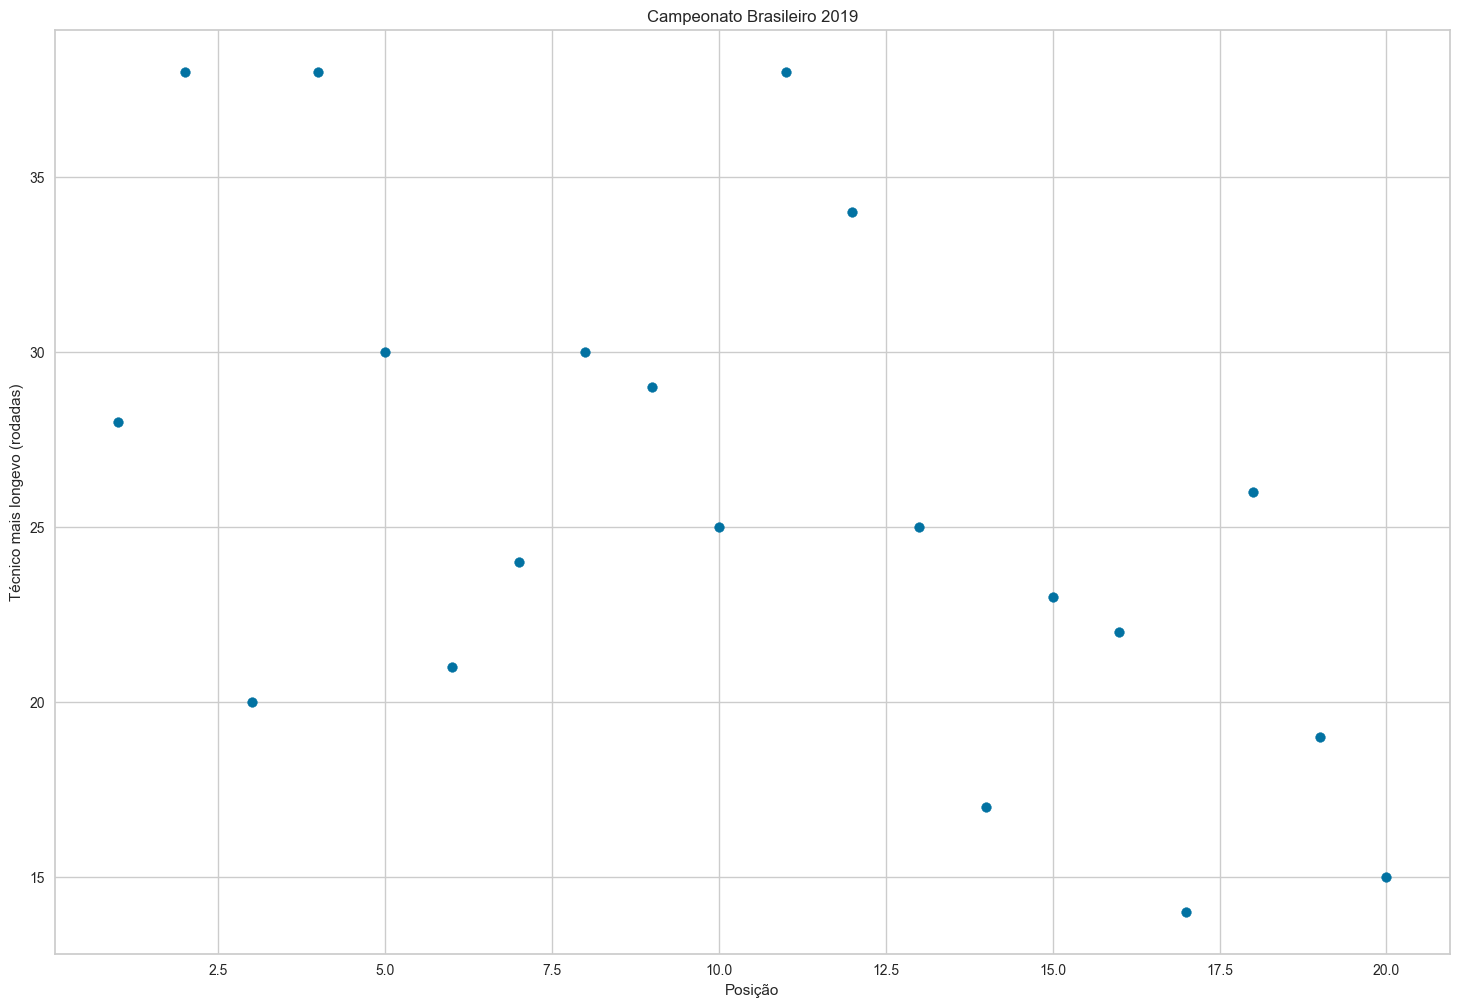

In [11]:
plt.figure(figsize=(18,12))
plt.title('Campeonato Brasileiro 2019')
legenda = []
plt.scatter(pos_plot, longev_plot)
  #legenda.append(resultado[1] + " (" + resultado[2]["nome"] + ")")
#plt.legend(legenda)
plt.xlabel('Posição')
plt.ylabel('Técnico mais longevo (rodadas)')
plt.grid(True)
plt.xscale('linear')

# Solucao Ane

In [12]:
#Calculo de pontos, vitorias,empates,derrotas,saldo de gols,gols pro e gols contra de todas as partidas - resultado final por time


def calcular_resultados_brasileirao(dados):
  resultados = {}

  for n_rodada in range(1,39):
    for n_partida in range(0,10):
      partida = dados[n_rodada][n_partida]
      time1 = partida["clubs"]["home"]
      time2 = partida["clubs"]["away"]
      gols1 = int(partida["goals"]["home"])
      gols2 = int(partida["goals"]["away"])

      #PARTE 1 - ANÁLISE DE GOLS
      # chave1 = time1
      resultado1 = resultados.get(time1)
      if resultado1 == None:
        resultado1 = resultados[time1] = {"time": time1,"P":0,"V":0,"E":0,"D":0,"GP":0,"GC":0,"SG":0,"treinadores":{},"max_treinador_rodadas":{"nome":"","rodadas":0}}

      #chave = time2
      resultado2 = resultados.get(time2)
      if resultado2 == None:
        resultado2 = resultados[time2] = {"time": time2,"P":0,"V":0,"E":0,"D":0,"GP":0,"GC":0,"SG":0,"treinadores":{},"max_treinador_rodadas":{"nome":"","rodadas":0}}

      if gols1 > gols2: #ganhou time 1

        resultado1["P"] = resultado1["P"] + 3
        resultado1["V"] = resultado1["V"] + 1

        resultado2["D"] = resultado2["D"] + 1

      elif gols2 > gols1: #ganhou o time 2
        resultado1["D"] = resultado1["D"] + 1

        resultado2["P"] = resultado2["P"] + 3
        resultado2["V"] = resultado2["V"] + 1

      else:#EMPATE
        resultado1["P"] = resultado1["P"] + 1
        resultado1["E"] = resultado1["E"] + 1

        resultado2["P"] = resultado2["P"] + 1
        resultado2["E"] = resultado2["E"] + 1

      resultado1["GP"] = resultado1["GP"] + gols1
      resultado1["GC"] = resultado1["GC"] + gols2
      resultado1["SG"] = resultado1["SG"] + gols1 - gols2

      resultado2["GP"] = resultado2["GP"] + gols2
      resultado2["GC"] = resultado2["GC"] + gols1
      resultado2["SG"] = resultado2["SG"] + gols2 - gols1

      #PARTE 2 - ANÁLISE DE TREINADORES
      treinador1 = partida["coach"]["home"]
      treinador2 = partida["coach"]["away"]

      #PARTE 2.1 - ANÁLISE DE RODADAS
      if treinador1 not in resultado1["treinadores"]:
        resultado1["treinadores"][treinador1] = 0

      if treinador2 not in resultado2["treinadores"]:
        resultado2["treinadores"][treinador2] = 0

      treinadores1 = resultado1["treinadores"]
      treinadores2 = resultado2["treinadores"]

      treinador_rodadas1 = treinadores1[treinador1] + 1
      treinador_rodadas2 = treinadores2[treinador2] + 1

      treinadores1[treinador1] = treinador_rodadas1
      treinadores2[treinador2] = treinador_rodadas2

      #PARTE 2.2 - ANÁLISE DE LONGEVIDADE
      max_treinador_rodadas1 = resultado1["max_treinador_rodadas"]
      max_treinador_rodadas2 = resultado2["max_treinador_rodadas"]

      if treinador_rodadas1 > max_treinador_rodadas1["rodadas"]:
        max_treinador_rodadas1["rodadas"] = treinador_rodadas1
        max_treinador_rodadas1["nome"] = treinador1

      if treinador_rodadas2 > max_treinador_rodadas2["rodadas"]:
        max_treinador_rodadas2["rodadas"] = treinador_rodadas2
        max_treinador_rodadas2["nome"] = treinador2

  return resultados


resultados = calcular_resultados_brasileirao(df)
    #print(time1,time1_goals,"X",time2_goals,time2)
print(resultados.values())
print(json.dumps(resultados))


def classificar_resultados(resultados):
  return [
      (index + 1, time["time"], time["max_treinador_rodadas"])
      for index, time in
        enumerate(
            sorted(
                  list(resultados.values()),
                  reverse = True,
                  key = lambda resultado: (resultado["P"], resultado["V"], resultado["GP"], resultado["SG"])
            )
        )
  ]

analise = classificar_resultados(resultados)
print(analise)

dict_values([{'time': 'São Paulo', 'P': 63, 'V': 17, 'E': 12, 'D': 9, 'GP': 39, 'GC': 30, 'SG': 9, 'treinadores': {'A. Stival': 21, 'F. Diniz Silva': 16, 'M. Longo de Araújo': 1}, 'max_treinador_rodadas': {'nome': 'A. Stival', 'rodadas': 21}}, {'time': 'Botafogo', 'P': 43, 'V': 13, 'E': 4, 'D': 21, 'GP': 31, 'GC': 45, 'SG': -14, 'treinadores': {'E. de Souza Barroca': 23, 'B. Lazaroni': 2, 'A. Valentim do Carmo Neto': 13}, 'max_treinador_rodadas': {'nome': 'E. de Souza Barroca', 'rodadas': 23}}, {'time': 'Atlético-MG', 'P': 48, 'V': 13, 'E': 9, 'D': 16, 'GP': 45, 'GC': 49, 'SG': -4, 'treinadores': {'R. Marques Santana': 25, 'V. Carmo Mancini': 13}, 'max_treinador_rodadas': {'nome': 'R. Marques Santana', 'rodadas': 25}}, {'time': 'Avaí', 'P': 20, 'V': 3, 'E': 11, 'D': 24, 'GP': 18, 'GC': 62, 'SG': -44, 'treinadores': {'E. Machado Souto': 9, 'A. Valentim do Carmo Neto': 15, 'E. Spinassé Camillato': 14}, 'max_treinador_rodadas': {'nome': 'A. Valentim do Carmo Neto', 'rodadas': 15}}, {'time

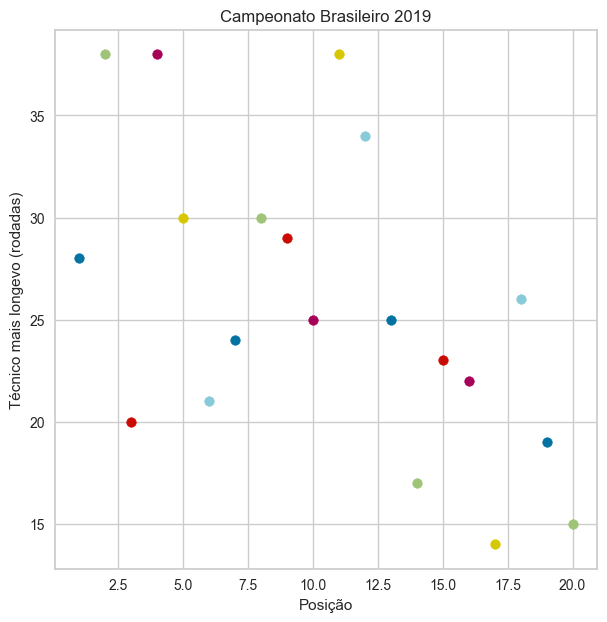

In [13]:
def plotar_analise(analise):
    plt.figure(figsize=(7,7))
    plt.title('Campeonato Brasileiro 2019')
    # legenda = []
    for resultado in analise:
      plt.scatter(resultado[0],resultado[2]["rodadas"])
    #   legenda.append(resultado[1] + " (" + resultado[2]["nome"] + ")")
    # plt.legend(legenda)
    plt.xlabel('Posição')
    plt.ylabel('Técnico mais longevo (rodadas)')
    plt.grid(True)
    plt.xscale('linear')

plotar_analise(analise)

## Todo código em uma célula Versão Geral

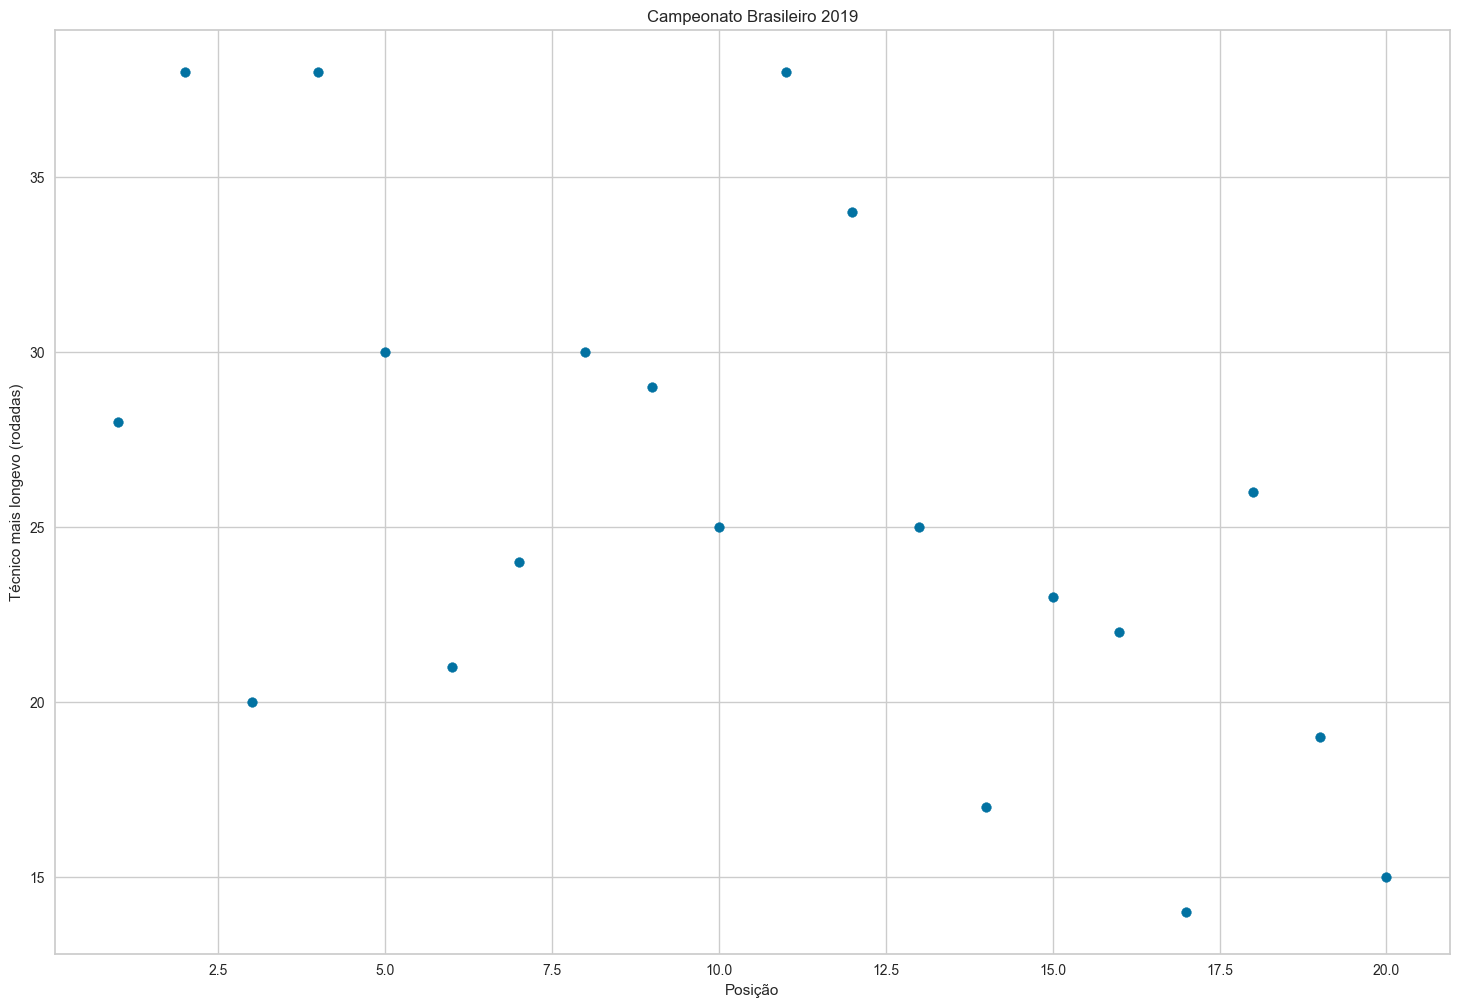

In [14]:
plot_campeonato('/Users/chenyenpin/Documents/ADA-Pr1/dados/brasileirao-2019.json')

In [15]:
logevidade=pd.DataFrame(longev_plot)

In [16]:
logevidade

,0
0,28
1,38
2,20
3,38
4,30
5,21
6,24
7,30
8,29
9,25


In [17]:
df_class=pd.DataFrame(times_ordenados).T

In [18]:
df_class=df_class.reset_index()

In [19]:
df_final=pd.concat([df_class, logevidade], axis=1 )
df_final.columns=[
    "time",
    "ponto_final",
    "vitorias",
    "saldo_gol",
    "total_gol",
    "longevidade"
    ]

In [20]:

df_final=feature_engineering(df_final)
df_final

,time,ponto_final,vitorias,saldo_gol,total_gol,longevidade,classificacao,gol_sofrido,relacao_gols,gol_jogo,longev_rela
0,Flamengo,90,28,49,86,28,1,37,2.324324,2.263158,0.736842
1,Santos,74,22,27,60,38,2,33,1.818182,1.578947,1.000000
2,Palmeiras,74,21,29,61,20,3,32,1.906250,1.605263,0.526316
3,Grêmio,65,19,25,64,38,4,39,1.641026,1.684211,1.000000
4,Athletico-PR,64,18,19,51,30,5,32,1.593750,1.342105,0.789474
5,São Paulo,63,17,9,39,21,6,30,1.300000,1.026316,0.552632
6,Internacional,57,16,5,44,24,7,39,1.128205,1.157895,0.631579
7,Corinthians,56,14,8,42,30,8,34,1.235294,1.105263,0.789474
8,Fortaleza,53,15,1,50,29,9,49,1.020408,1.315789,0.763158
9,Goiás,52,15,-18,46,25,10,64,0.718750,1.210526,0.657895


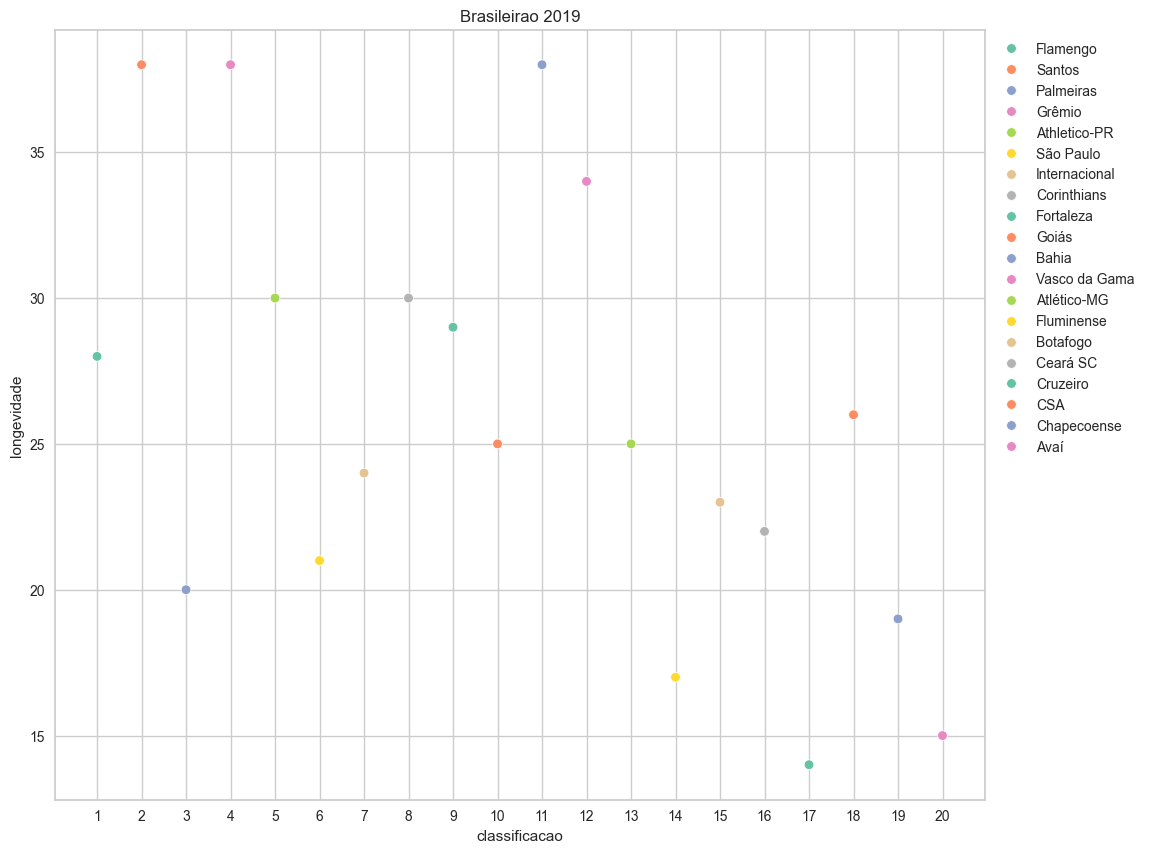

In [21]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=df_final, x="classificacao", y="longevidade", palette="Set2", hue="time",)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(list(range(1,max(df_final["classificacao"])+1)),[str(i) for i in range(1,max(df_final["classificacao"])+1)])
plt.title("Brasileirao 2019")
plt.show()


# ML CLUSTER

In [22]:
df_final=feature_engineering(df_final)
df_final

,time,ponto_final,vitorias,saldo_gol,total_gol,longevidade,classificacao,gol_sofrido,relacao_gols,gol_jogo,longev_rela
0,Flamengo,90,28,49,86,28,1,37,2.324324,2.263158,0.736842
1,Santos,74,22,27,60,38,2,33,1.818182,1.578947,1.000000
2,Palmeiras,74,21,29,61,20,3,32,1.906250,1.605263,0.526316
3,Grêmio,65,19,25,64,38,4,39,1.641026,1.684211,1.000000
4,Athletico-PR,64,18,19,51,30,5,32,1.593750,1.342105,0.789474
5,São Paulo,63,17,9,39,21,6,30,1.300000,1.026316,0.552632
6,Internacional,57,16,5,44,24,7,39,1.128205,1.157895,0.631579
7,Corinthians,56,14,8,42,30,8,34,1.235294,1.105263,0.789474
8,Fortaleza,53,15,1,50,29,9,49,1.020408,1.315789,0.763158
9,Goiás,52,15,-18,46,25,10,64,0.718750,1.210526,0.657895


In [23]:
num_col=df_final.select_dtypes("number").columns.tolist()

In [24]:
corr=df_final[num_col].corr()
corr

,ponto_final,vitorias,saldo_gol,total_gol,longevidade,classificacao,gol_sofrido,relacao_gols,gol_jogo,longev_rela
ponto_final,1.000000,0.988213,0.962281,0.935497,0.483741,-0.970028,-0.716262,0.964921,0.935497,0.483741
vitorias,0.988213,1.000000,0.939997,0.942022,0.481523,-0.950778,-0.655046,0.945587,0.942022,0.481523
saldo_gol,0.962281,0.939997,1.000000,0.929518,0.501910,-0.930769,-0.811858,0.984106,0.929518,0.501910
total_gol,0.935497,0.942022,0.929518,1.000000,0.520959,-0.886634,-0.539324,0.930901,1.000000,0.520959
longevidade,0.483741,0.481523,0.501910,0.520959,1.000000,-0.549310,-0.321315,0.466205,0.520959,1.000000
classificacao,-0.970028,-0.950778,-0.930769,-0.886634,-0.549310,1.000000,0.721663,-0.937231,-0.886634,-0.549310
gol_sofrido,-0.716262,-0.655046,-0.811858,-0.539324,-0.321315,0.721663,1.000000,-0.773374,-0.539324,-0.321315
relacao_gols,0.964921,0.945587,0.984106,0.930901,0.466205,-0.937231,-0.773374,1.000000,0.930901,0.466205
gol_jogo,0.935497,0.942022,0.929518,1.000000,0.520959,-0.886634,-0.539324,0.930901,1.000000,0.520959
longev_rela,0.483741,0.481523,0.501910,0.520959,1.000000,-0.549310,-0.321315,0.466205,0.520959,1.000000


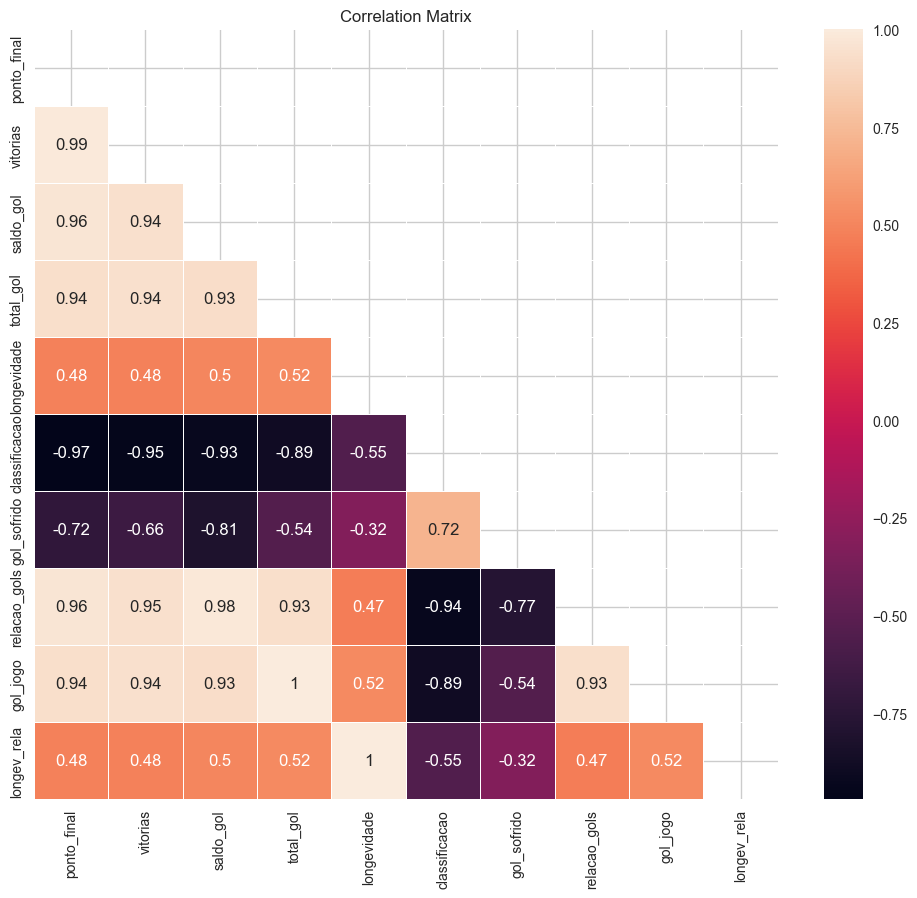

In [25]:
mask=np.triu(np.ones_like(corr))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True, linewidths=0.5)
plt.yticks(rotation=90)
plt.title('Correlation Matrix')
plt.show()


In [26]:
cat_col=df_final.select_dtypes(exclude="number").columns.tolist()
num_col=[col for col in df_final if col not in cat_col]

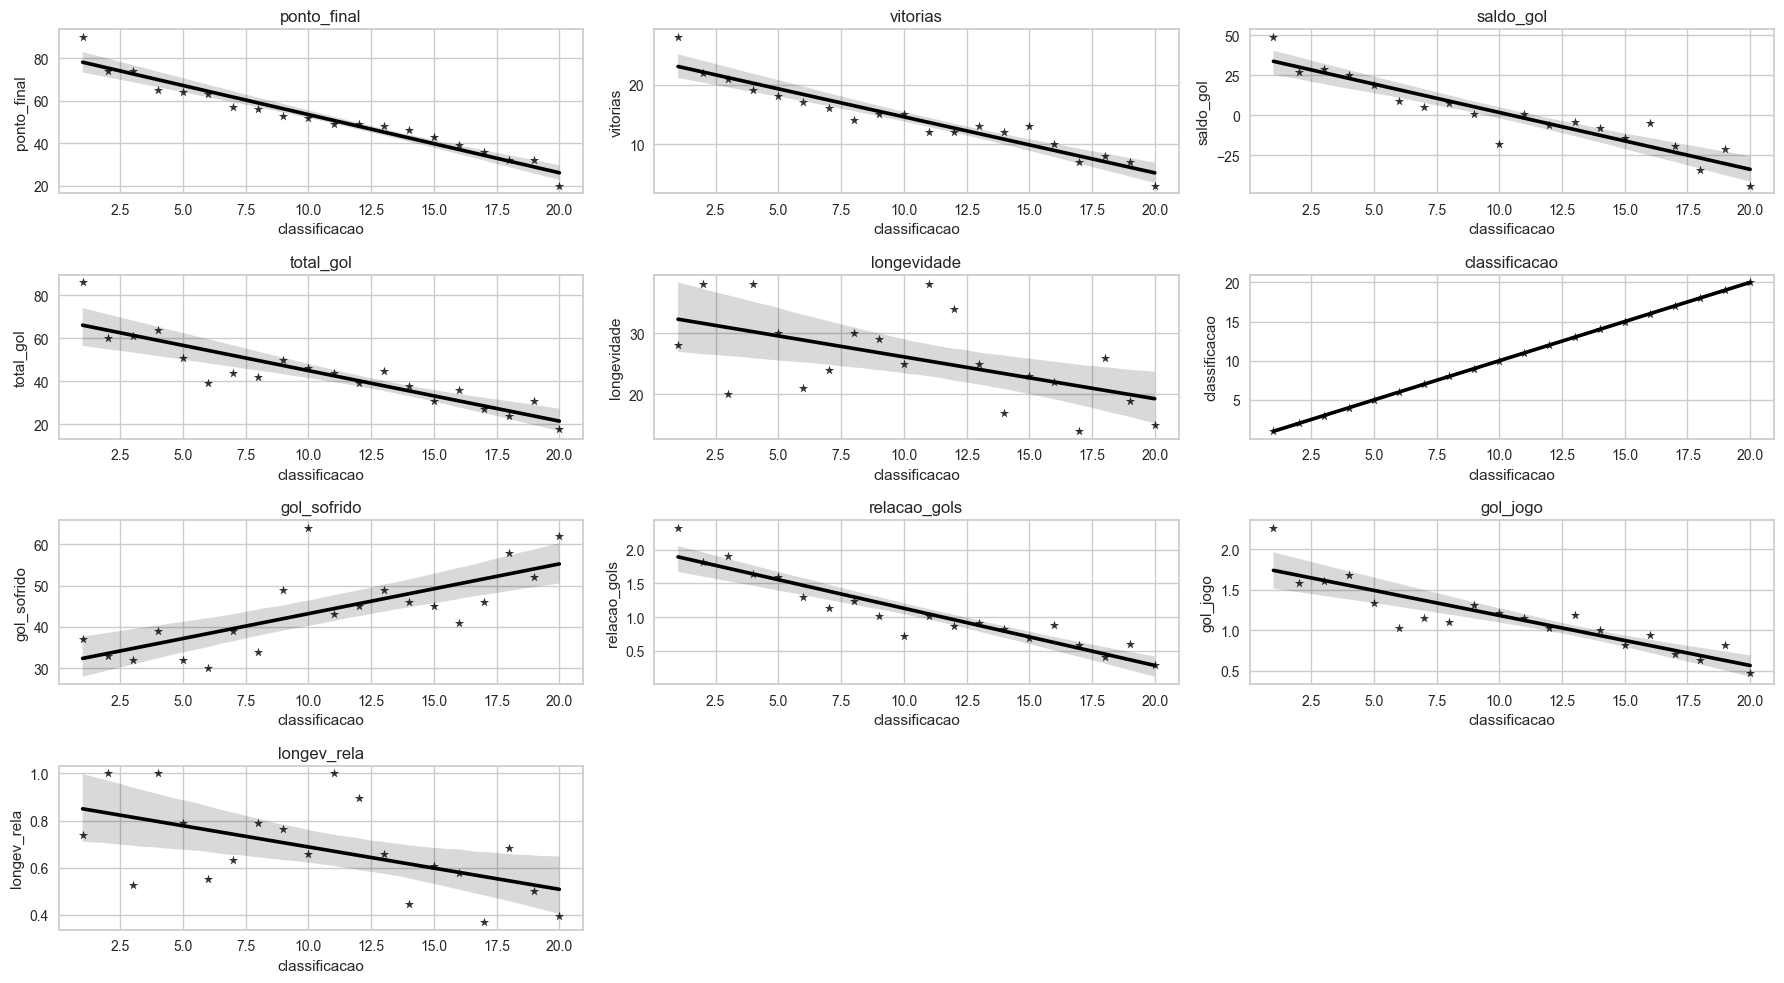

In [27]:
plt.figure(figsize=(18,10))
for i , num in enumerate(num_col):
    ax=plt.subplot(4, 3, i+1)
    sns.regplot(data=df_final, y=num, x="classificacao", fit_reg=True,color="black", marker="*")
    plt.title(num)
    plt.tight_layout()

In [28]:
df_cluster=df_final.drop(columns=["time", "classificacao"])

<Axes: >

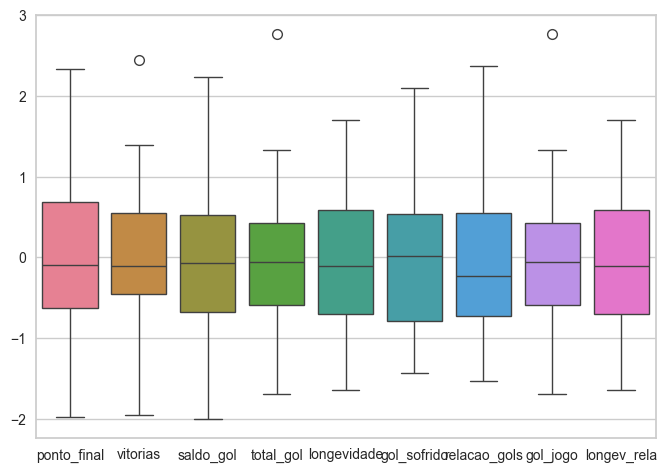

In [29]:
sns.boxplot(df_cluster.apply(scale))

In [30]:
df_scale=df_cluster.apply(scale)

In [31]:
x=df_scale

/Users/chenyenpin/opt/anaconda3/envs/myvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chenyenpin/opt/anaconda3/envs/myvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chenyenpin/opt/anaconda3/envs/myvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chenyenpin/opt/anaconda3/envs/myvenv/lib/python3.9/site-packages/sklearn/cluster/

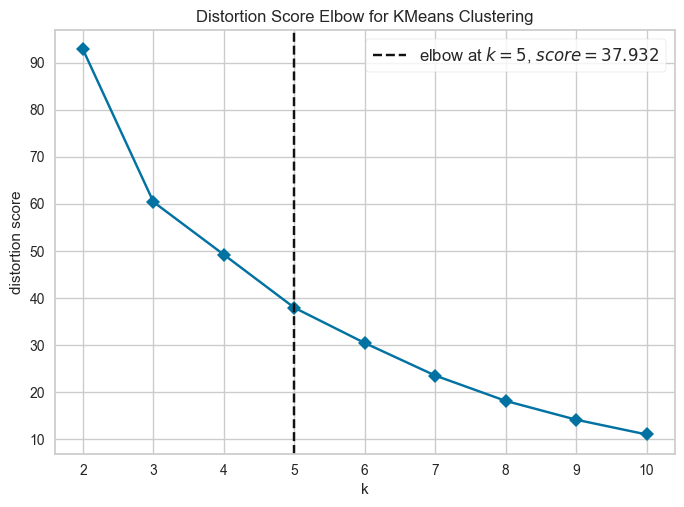

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [32]:
kelbow_visualizer(KMeans(), x, k=10, timings=False)

In [33]:
model=KMeans(n_clusters=4, random_state=101)
model.fit_predict(x)

/Users/chenyenpin/opt/anaconda3/envs/myvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 2, 3, 2, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

/Users/chenyenpin/opt/anaconda3/envs/myvenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


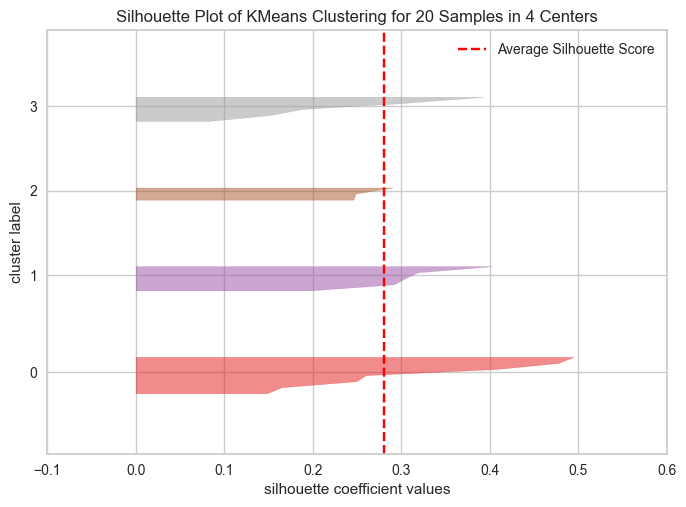

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 20 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4, random_state=101))

In [34]:
silhouette_visualizer(model, x)

In [35]:
labels=model.labels_
centers= pd.DataFrame(model.cluster_centers_, columns=df_cluster.columns)
centers

,ponto_final,vitorias,saldo_gol,total_gol,longevidade,gol_sofrido,relacao_gols,gol_jogo,longev_rela
0,-1.025298,-0.969925,-0.941364,-0.951353,-0.889046,0.643395,-0.915153,-0.951353,-0.889046
1,-0.116851,-0.122807,-0.236315,0.065546,0.613960,0.643395,-0.343700,0.065546,0.613960
2,1.490358,1.561404,1.529987,1.717304,1.237223,-0.774841,1.608959,1.717304,1.237223
3,0.658054,0.543860,0.636232,0.235965,-0.111629,-1.079242,0.659538,0.235965,-0.111629


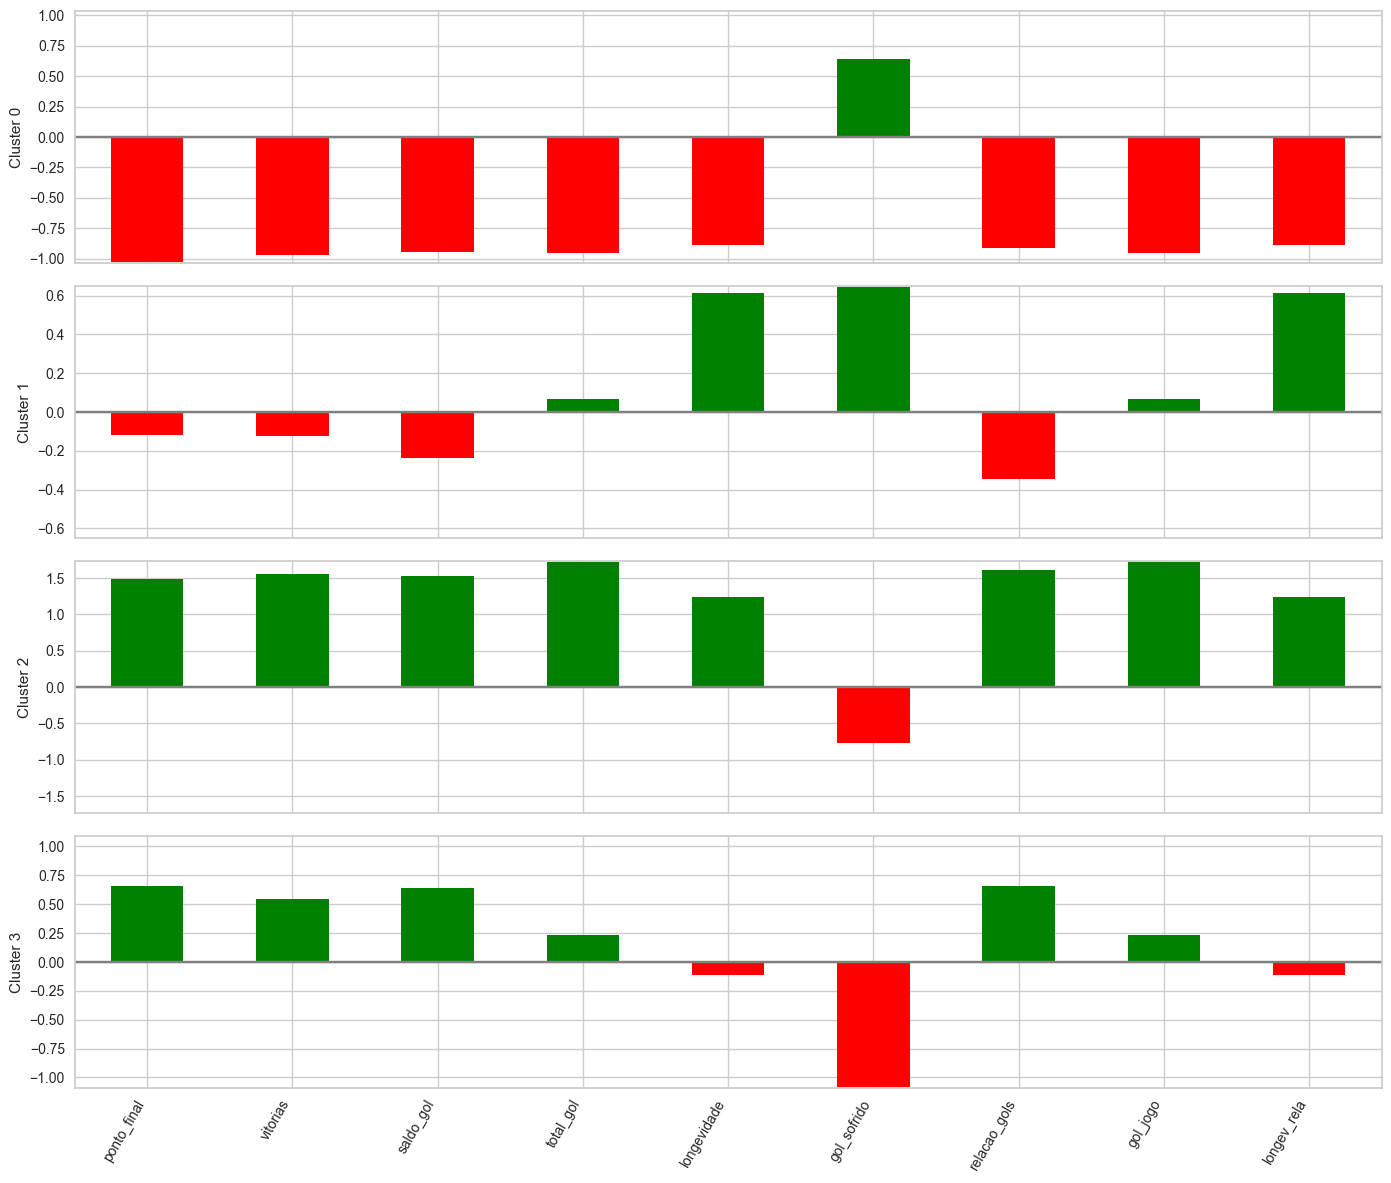

In [36]:
#plotando as caracteristicas dos noss clusters

fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [37]:
labels=pd.DataFrame(labels)

In [38]:
df_final=pd.merge(df_final, labels, how="left", left_index=True, right_index=True)

In [39]:
df_final.loc[df_final[0]==1]

,time,ponto_final,vitorias,saldo_gol,total_gol,longevidade,classificacao,gol_sofrido,relacao_gols,gol_jogo,longev_rela,0
8,Fortaleza,53,15,1,50,29,9,49,1.020408,1.315789,0.763158,1
9,Goiás,52,15,-18,46,25,10,64,0.718750,1.210526,0.657895,1
10,Bahia,49,12,1,44,38,11,43,1.023256,1.157895,1.000000,1
11,Vasco da Gama,49,12,-6,39,34,12,45,0.866667,1.026316,0.894737,1
12,Atlético-MG,48,13,-4,45,25,13,49,0.918367,1.184211,0.657895,1
